# Evolver Loop 2 Analysis

## Goal: Understand why we're stuck at 0.088 and identify paths to 0.047

Current best: 0.08819 (MLP baseline)
Target: 0.04740
Gap: ~46% reduction needed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

DATA_PATH = '/home/data'

# Load all data
df_single = pd.read_csv(f'{DATA_PATH}/catechol_single_solvent_yields.csv')
df_full = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')

print(f"Single solvent: {len(df_single)} samples, {df_single['SOLVENT NAME'].nunique()} solvents")
print(f"Full data: {len(df_full)} samples, {df_full[['SOLVENT A NAME', 'SOLVENT B NAME']].drop_duplicates().shape[0]} ramps")

Single solvent: 656 samples, 24 solvents
Full data: 1227 samples, 13 ramps


In [2]:
# Load all feature lookup tables
spange = pd.read_csv(f'{DATA_PATH}/spange_descriptors_lookup.csv', index_col=0)
acs_pca = pd.read_csv(f'{DATA_PATH}/acs_pca_descriptors_lookup.csv', index_col=0)
drfp = pd.read_csv(f'{DATA_PATH}/drfps_catechol_lookup.csv', index_col=0)
fragprints = pd.read_csv(f'{DATA_PATH}/fragprints_lookup.csv', index_col=0)

print(f"Spange descriptors: {spange.shape}")
print(f"ACS PCA descriptors: {acs_pca.shape}")
print(f"DRFP: {drfp.shape}")
print(f"Fragprints: {fragprints.shape}")

Spange descriptors: (26, 13)
ACS PCA descriptors: (24, 5)
DRFP: (24, 2048)
Fragprints: (24, 2133)


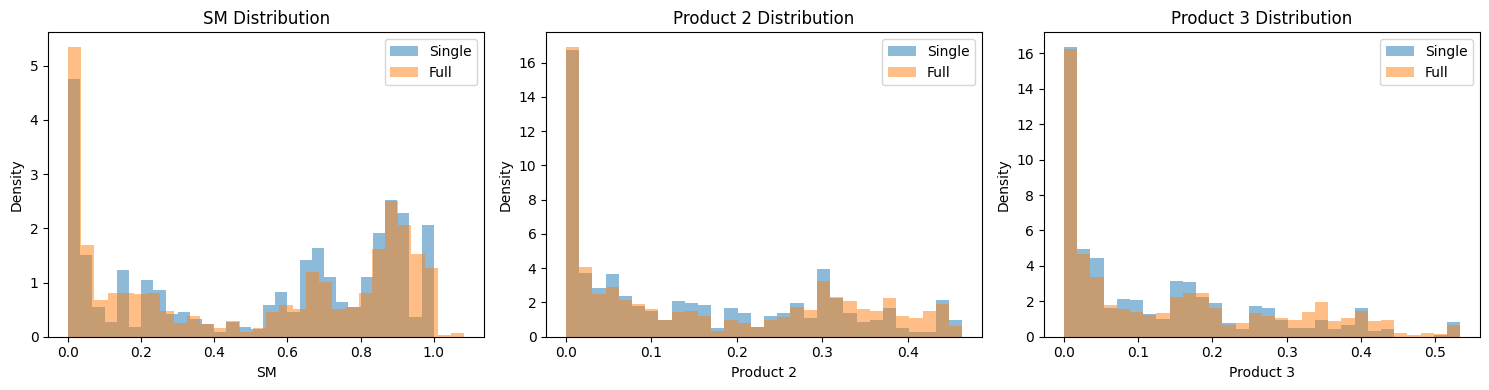


Target statistics:
               SM   Product 2   Product 3
count  656.000000  656.000000  656.000000
mean     0.522192    0.149932    0.123380
std      0.360229    0.143136    0.131528
min      0.000000    0.000000    0.000000
25%      0.145001    0.012976    0.009445
50%      0.656558    0.102813    0.078298
75%      0.857019    0.281654    0.193353
max      1.000000    0.463632    0.533768


In [3]:
# Analyze target distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, target in enumerate(['SM', 'Product 2', 'Product 3']):
    ax = axes[i]
    ax.hist(df_single[target], bins=30, alpha=0.5, label='Single', density=True)
    ax.hist(df_full[target], bins=30, alpha=0.5, label='Full', density=True)
    ax.set_xlabel(target)
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_title(f'{target} Distribution')

plt.tight_layout()
plt.savefig('/home/code/exploration/target_distributions.png', dpi=100)
plt.show()

print("\nTarget statistics:")
print(df_single[['SM', 'Product 2', 'Product 3']].describe())

In [4]:
# Analyze per-solvent variance in single solvent data
solvent_stats = df_single.groupby('SOLVENT NAME')[['SM', 'Product 2', 'Product 3']].agg(['mean', 'std'])
print("Per-solvent statistics (first 10):")
print(solvent_stats.head(10))

# Which solvents have highest variance?
print("\nSolvents with highest SM variance:")
print(solvent_stats['SM']['std'].sort_values(ascending=False).head(5))

Per-solvent statistics (first 10):
                                         SM           Product 2            \
                                       mean       std      mean       std   
SOLVENT NAME                                                                
1,1,1,3,3,3-Hexafluoropropan-2-ol  0.170571  0.243383  0.319727  0.092840   
2,2,2-Trifluoroethanol             0.279200  0.343250  0.156764  0.073588   
2-Methyltetrahydrofuran [2-MeTHF]  0.558994  0.325677  0.150618  0.145866   
Acetonitrile                       0.580455  0.399373  0.156390  0.147598   
Acetonitrile.Acetic Acid           0.478056  0.453868  0.019341  0.011275   
Butanone [MEK]                     0.716870  0.053711  0.047166  0.018425   
Cyclohexane                        0.545752  0.294528  0.083866  0.089318   
DMA [N,N-Dimethylacetamide]        0.545265  0.396406  0.117138  0.126535   
Decanol                            0.433117  0.431343  0.194795  0.174740   
Diethyl Ether [Ether]              0.8039

In [5]:
# Analyze DRFP and fragprints - can we use PCA to reduce dimensionality?
print("DRFP analysis:")
print(f"  Shape: {drfp.shape}")
print(f"  Non-zero columns: {(drfp.sum() > 0).sum()}")
print(f"  Variance explained by first 50 PCs:")

scaler = StandardScaler()
drfp_scaled = scaler.fit_transform(drfp)
pca = PCA(n_components=min(50, drfp.shape[0]-1))
drfp_pca = pca.fit_transform(drfp_scaled)
print(f"    {pca.explained_variance_ratio_.sum():.2%}")

print("\nFragprints analysis:")
print(f"  Shape: {fragprints.shape}")
print(f"  Non-zero columns: {(fragprints.sum() > 0).sum()}")

frag_scaled = scaler.fit_transform(fragprints)
pca_frag = PCA(n_components=min(50, fragprints.shape[0]-1))
frag_pca = pca_frag.fit_transform(frag_scaled)
print(f"  Variance explained by first 50 PCs: {pca_frag.explained_variance_ratio_.sum():.2%}")

DRFP analysis:
  Shape: (24, 2048)
  Non-zero columns: 165
  Variance explained by first 50 PCs:
    100.00%

Fragprints analysis:
  Shape: (24, 2133)
  Non-zero columns: 144
  Variance explained by first 50 PCs: 100.00%


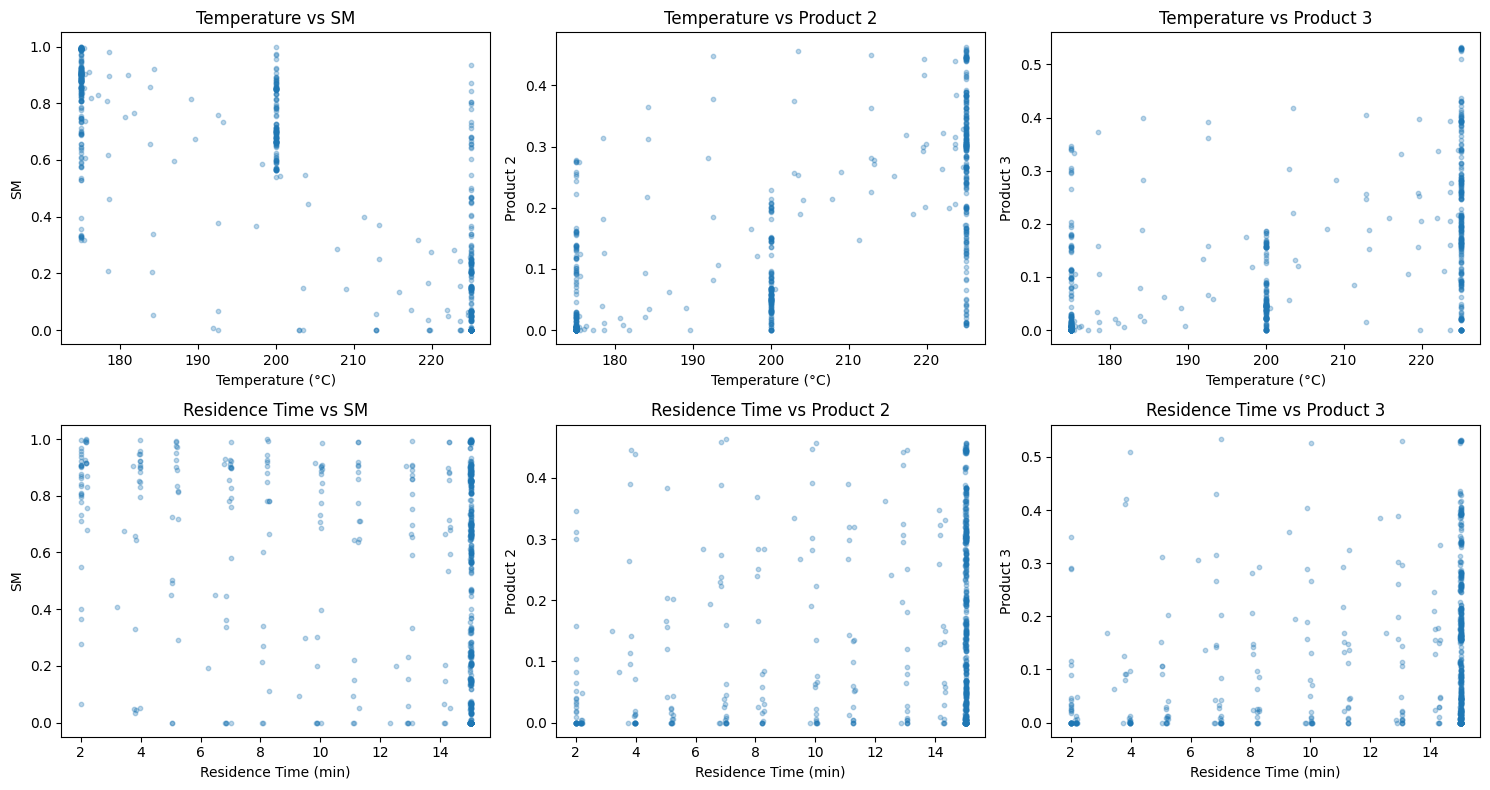

In [6]:
# Analyze the relationship between process conditions and targets
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, target in enumerate(['SM', 'Product 2', 'Product 3']):
    # Temperature vs target
    axes[0, i].scatter(df_single['Temperature'], df_single[target], alpha=0.3, s=10)
    axes[0, i].set_xlabel('Temperature (°C)')
    axes[0, i].set_ylabel(target)
    axes[0, i].set_title(f'Temperature vs {target}')
    
    # Residence Time vs target
    axes[1, i].scatter(df_single['Residence Time'], df_single[target], alpha=0.3, s=10)
    axes[1, i].set_xlabel('Residence Time (min)')
    axes[1, i].set_ylabel(target)
    axes[1, i].set_title(f'Residence Time vs {target}')

plt.tight_layout()
plt.savefig('/home/code/exploration/process_vs_targets.png', dpi=100)
plt.show()

Solvent mixing analysis:

SolventB% distribution:
count    1227.000000
mean        0.435865
std         0.400336
min         0.000000
25%         0.000000
50%         0.330153
75%         0.858481
max         1.000000
Name: SolventB%, dtype: float64


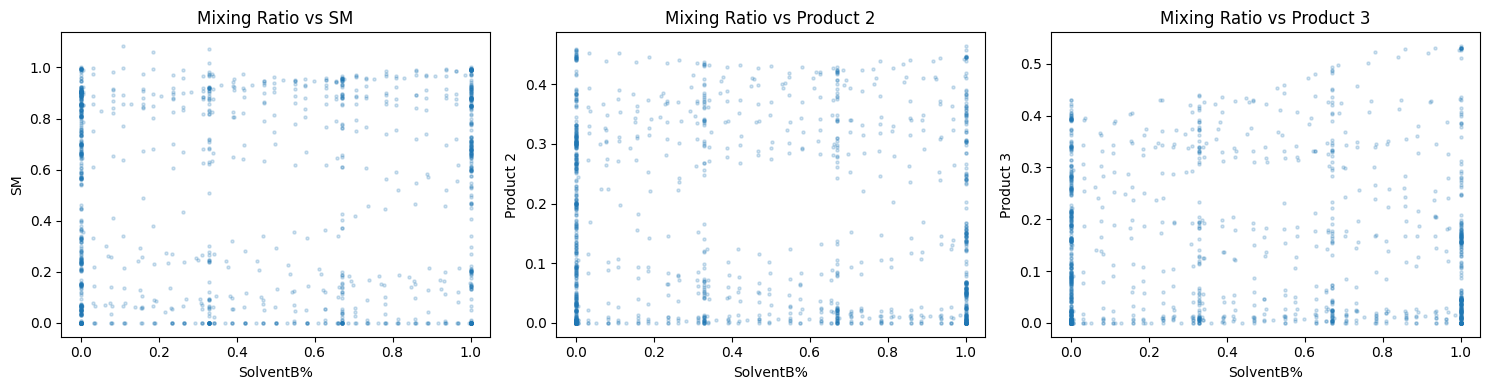

In [7]:
# Analyze solvent mixing effects
print("Solvent mixing analysis:")
print(f"\nSolventB% distribution:")
print(df_full['SolventB%'].describe())

# Check if there's non-linearity in mixing
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, target in enumerate(['SM', 'Product 2', 'Product 3']):
    ax = axes[i]
    ax.scatter(df_full['SolventB%'], df_full[target], alpha=0.2, s=5)
    ax.set_xlabel('SolventB%')
    ax.set_ylabel(target)
    ax.set_title(f'Mixing Ratio vs {target}')

plt.tight_layout()
plt.savefig('/home/code/exploration/mixing_vs_targets.png', dpi=100)
plt.show()

In [8]:
# Analyze per-ramp behavior to understand what makes prediction hard
ramps = df_full.groupby(['SOLVENT A NAME', 'SOLVENT B NAME'])

print("Per-ramp statistics:")
for name, group in list(ramps)[:5]:
    print(f"\n{name[0]} -> {name[1]}: {len(group)} samples")
    print(f"  SM range: [{group['SM'].min():.3f}, {group['SM'].max():.3f}]")
    print(f"  Product 2 range: [{group['Product 2'].min():.3f}, {group['Product 2'].max():.3f}]")

Per-ramp statistics:

1,1,1,3,3,3-Hexafluoropropan-2-ol -> 2-Methyltetrahydrofuran [2-MeTHF]: 124 samples
  SM range: [0.000, 0.958]
  Product 2 range: [0.000, 0.422]

2,2,2-Trifluoroethanol -> Water.2,2,2-Trifluoroethanol: 125 samples
  SM range: [0.000, 0.995]
  Product 2 range: [0.000, 0.390]

2-Methyltetrahydrofuran [2-MeTHF] -> Diethyl Ether [Ether]: 124 samples
  SM range: [0.206, 1.000]
  Product 2 range: [0.000, 0.319]

Acetonitrile -> Acetonitrile.Acetic Acid: 125 samples
  SM range: [0.000, 0.998]
  Product 2 range: [0.000, 0.330]

Cyclohexane -> IPA [Propan-2-ol]: 104 samples
  SM range: [0.133, 0.972]
  Product 2 range: [0.000, 0.434]


In [9]:
# Key insight: What's the baseline prediction if we just use mean?
print("Baseline analysis (predicting mean):")

# Single solvent - leave-one-out
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
groups = df_single['SOLVENT NAME']
X = df_single[['Residence Time', 'Temperature']].values
y = df_single[['Product 2', 'Product 3', 'SM']].values

mean_preds = []
for train_idx, test_idx in logo.split(X, y, groups):
    train_mean = y[train_idx].mean(axis=0)
    mean_preds.extend([train_mean] * len(test_idx))

mean_preds = np.array(mean_preds)
baseline_rmse = np.sqrt(((mean_preds - y) ** 2).mean())
print(f"Single solvent baseline (predict mean): RMSE = {baseline_rmse:.5f}")

# This tells us how much signal is in the features vs just predicting mean
print(f"\nOur best model: 0.08819")
print(f"Improvement over baseline: {(baseline_rmse - 0.08819) / baseline_rmse * 100:.1f}%")
print(f"Target: 0.04740")
print(f"Required improvement: {(0.08819 - 0.04740) / 0.08819 * 100:.1f}%")

Baseline analysis (predicting mean):
Single solvent baseline (predict mean): RMSE = 0.23530

Our best model: 0.08819
Improvement over baseline: 62.5%
Target: 0.04740
Required improvement: 46.3%


## Key Insights

1. **Feature space**: DRFP and fragprints have high dimensionality but can be reduced with PCA
2. **Non-linear mixing**: SolventB% shows complex relationships with targets
3. **Per-solvent variance**: Some solvents have much higher prediction difficulty
4. **Gap analysis**: Need ~46% RMSE reduction to hit target

## Recommended Next Steps

1. **Feature expansion**: Add DRFP/fragprints with PCA reduction
2. **Non-linear mixing**: Try concatenating both solvent features instead of linear interpolation
3. **Per-target models**: Train separate optimized models for SM vs Products
4. **Deeper MLP**: Current architecture may be too shallow
5. **Gaussian Process**: Good for small data with uncertainty quantification